# Categorizing Chicago Communities using Crime Data and Foursquare

## Table of contents
* [Introduction / Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction / Business Problem <a name="introduction"></a>

The objective of this project is to obtain the safest communities taking into account the crime rate. The result of this study is aimed at those interested in living in the city of Chicago.

Chicago is one of the largest cities of the united states with a population of over 2 and a half million people. Chicago has 77 communities grouped into 9 districts.  The city has reported more than 7 million crimes of every category since 2001, 259 thousand just in 2019.  Business Problem  We will deal with the decision of “Which community has had the least crimes in 2019”, finding the right community to move into or beginning a business entrepreneurship based on the security and venue(residence) density in each community. 
 

## Data <a name="data"></a>

Our study will be based on the data extracted from:
 * Crime Data(using the datasets provided by <a target='new' href='https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g'>the city of chicago</a>)
 * Community information(scraped from <a target='new' href='https://en.wikipedia.org/wiki/Community_areas_in_Chicago'>this wikipedia page</a>)
 	* Using geopy to get each coordinate
 * Foursquare api to explore residences near our communities
 
**The study will be made using 2019 data**.
 

In [269]:
import pandas as pd
import numpy as np
import scipy
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot


# import k-means from clustering stage
from sklearn.cluster import KMeans

import requests
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install lxml
import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

Solving environment: done

# All requested packages already installed.



**Since we downloaded the data corresponding to 2019 into a csv file named: ChicagoCrimes2019.csv we proceed to utilize it**

In [270]:
df_crimes = pd.read_csv('ChicagoCrimes2019.csv')
df_crimes.shape

(259004, 22)

In [271]:
df_crimes.head()

ID Case Number                    Date                    Block  \
0  11965029    JD132142  01/01/2019 12:00:00 AM  028XX W SHAKESPEARE AVE   
1  11752916    JC342540  01/01/2019 12:00:00 AM        036XX W THOMAS ST   
2  11739188    JC326320  01/01/2019 12:00:00 AM     010XX N RIDGEWAY AVE   
3  11737723    JC323962  01/01/2019 12:00:00 AM     028XX S ST LOUIS AVE   
4  11992909    JD166116  01/01/2019 12:00:00 AM       014XX N KEELER AVE   

   IUCR                Primary Type  \
0  1752  OFFENSE INVOLVING CHILDREN   
1  1752  OFFENSE INVOLVING CHILDREN   
2  1752  OFFENSE INVOLVING CHILDREN   
3  1562                 SEX OFFENSE   
4  1562                 SEX OFFENSE   

                                         Description Location Description  \
0  AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER            APARTMENT   
1  AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER            APARTMENT   
2  AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER            APARTMENT   
3                   AGGRAVATED CRIMINAL SEXUAL ABUSE            APARTMENT   
4                   AGGRAVATED CRIMINAL SEXUAL ABUSE            RESIDENCE   

   Arrest  Domestic  ...  Ward  Community Area  FBI Code  X Coordinate  \
0   False      True  ...   1.0            22.0        17     1156820.0   
1   False     False  ...  27.0            23.0        17     1151715.0   
2   False      True  ...  27.0            23.0        17     1151192.0   
3   False      True  ...  22.0            30.0        17     1153496.0   
4   False     False  ...  26.0            23.0        17     1148120.0   

  Y Coordinate  Year              Updated On   Latitude  Longitude  \
0    1914304.0  2019  04/20/2020 03:47:53 PM  41.920626 -87.699237   
1    1907084.0  2019  04/19/2020 03:44:21 PM  41.900916 -87.718184   
2    1906670.0  2019  04/19/2020 03:44:21 PM  41.899790 -87.720116   
3    1884904.0  2019  04/19/2020 03:44:21 PM  41.840016 -87.712231   
4    1909302.0  2019  03/23/2020 03:47:32 PM  41.907072 -87.731331   

                        Location  
0  (41.920626036, -87.699236545)  
1  (41.900915738, -87.718183718)  
2  (41.899789956, -87.720115618)  
3  (41.840016176, -87.712231415)  
4  (41.907072136, -87.731331357)  

[5 rows x 22 columns]

**Crime Data preliminar cleaning**

In [272]:
#take only the rows with location data
df_crimes= df_crimes[df_crimes['Latitude'].notna()]
df_crimes= df_crimes[df_crimes['Longitude'].notna()]
#remove unnecessary columns
df_crimes.drop(df_crimes.columns.difference(['Community Area','Latitude','Longitude']), 1, inplace=True)
#rename for ease of access
df_crimes = df_crimes.rename(columns={"Community Area": "CommunityArea"})
#delete rows that dont have a community
df_crimes = df_crimes[df_crimes.CommunityArea != 0]
#modfiy dataframe to contain each community and the total of crimes
df_crimes = df_crimes.groupby(["CommunityArea"])["CommunityArea"].count().reset_index(name="CrimeTotal")
df_crimes.shape

(77, 2)

Now we need a list of all communities, we use pandas to scrape the data from wikipedia

In [273]:
communities_raw_data = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago')
# the pandas read_html function reads all tables from the scraped webpage. Since chicago has 77 communities divided into 9 districts 
#we take the first 9 indexes
print('the object communities_raw_data is of type {}, has {} items of type {}'.format(type(communities_raw_data),
                                                                                      len(communities_raw_data),
                                                                                      type(communities_raw_data[0])))

the object communities_raw_data is of type <class 'list'>, has 12 items of type <class 'pandas.core.frame.DataFrame'>


**Now that we have a list of DataFrames containing all the community data, we proceed to merge each item into only 1 DataFrame**

In [274]:
# define the dataframe columns
column_names = ['CommunityNumber', 'CommunityAreaName'] 

# instantiate the dataframe
community_data = pd.DataFrame(columns=column_names)

for index in range(9):
    for r,data in communities_raw_data[index].iterrows():
        number =data.Number
        name = data['Community area']

        community_data = community_data.append({'CommunityNumber': number,
                                              'CommunityAreaName': name} , ignore_index=True)

community_data.head()

CommunityNumber CommunityAreaName
0               8   Near North Side
1              32              Loop
2              33   Near South Side
3               5      North Center
4               6         Lake View

### We need a function to obtain the location of each community 

In [275]:
#returns the latitud and longitude of a given community
def get_community_location(community):
    address = community+', Chicago, IL'
    geolocator = Nominatim(user_agent="chicago_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

The next step is to loop thru all communities and get each latitud,longitude


In [276]:
for i,data in community_data.iterrows():
    location= get_community_location(data.CommunityAreaName)
    community_data.at[i,'Latitude'] = location[0]
    community_data.at[i,'Longitude'] = location[1]
    
community_data.head()

CommunityNumber CommunityAreaName   Latitude  Longitude
0               8   Near North Side  41.900033 -87.634497
1              32              Loop  41.875562 -87.624421
2              33   Near South Side  41.856700 -87.624774
3               5      North Center  41.956107 -87.679160
4               6         Lake View  41.947050 -87.655429

### Foursquare configuration

In [277]:
#sets foursquare keys
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
#Since we are only using the Residency Category, we save the id in a variable
CATEGORY = '4e67e38e036454776db1fb3a'

In [12]:
def getNearbyResidences(id,names, latitudes, longitudes):
    venues_list=[]
    for id,name, lat, lng in zip(id,names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            CATEGORY, 
            LIMIT)
        #print(url)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            id,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'CommunityNumber',
        'CommunityName',
        'CommunityLatitude', 
        'CommunityLongitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category']
    
    return(nearby_venues)

In [278]:
chicago_residencies = getNearbyResidences(id=community_data['CommunityNumber'],names=community_data['CommunityAreaName'],
                                   latitudes=community_data['Latitude'],
                                   longitudes=community_data['Longitude']
                                  )
chicago_residencies.head()

CommunityNumber    CommunityName  CommunityLatitude  CommunityLongitude  \
0                8  Near North Side          41.900033          -87.634497   
1                8  Near North Side          41.900033          -87.634497   
2                8  Near North Side          41.900033          -87.634497   
3                8  Near North Side          41.900033          -87.634497   
4                8  Near North Side          41.900033          -87.634497   

                                               Venue  Venue Latitude  \
0                                       DeWitt Place       41.899483   
1  Trump International Hotel & Tower Chicago (Tru...       41.888938   
2                                       Maple Pointe       41.901623   
3                                          Niche 905       41.899353   
4                                      Parc Chestnut       41.897744   

   Venue Longitude                            Venue Category  
0       -87.620066  Residential Building (Apartment / Condo)  
1       -87.626354                                     Hotel  
2       -87.633804  Residential Building (Apartment / Condo)  
3       -87.636976  Residential Building (Apartment / Condo)  
4       -87.635741  Residential Building (Apartment / Condo)

In [279]:
chicago_location = get_community_location('')
chicago_location

(41.8755616, -87.6244212)

Lets start by just showing each community

In [280]:
# Create a map of chicago
map_chicago = folium.Map(location=chicago_location, zoom_start=10)

# add markers to map
for lat, lng, description in zip(community_data['Latitude'], community_data['Longitude'], community_data['CommunityAreaName']):
    label = description
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
map_clusters.save('CommunitiesMap.html')       
map_chicago

Now lets show each residence venue on every community

In [281]:
# Create a map of chicago
map_chicago = folium.Map(location=chicago_location, zoom_start=10)

# add markers to map
for lat, lng, community,residency in zip(chicago_residencies['Venue Latitude'], chicago_residencies['Venue Longitude'], chicago_residencies['CommunityName'], chicago_residencies['Venue']):
    label = '{},{}'.format(community,residency)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

## Methodology <a name="methodology"></a>

Now that we have our data, we will follow the following steps: 
* We'll be  doing exploratory analysis on our dataframes.
* We will investigate whether the number of existing 'residency' locations in communities affects the crime rate.
* Our selected algorithm will be **K-means** which we'll be using to cluster the different communities.

In order to provide the information as clear as possible, we will be using: **scatter plots, heatmaps and overlayed maps**.

## Anaylisis <a name="anaylisis"></a>

first we need to have the total crimes per community and merge all dataframes together

In [282]:
community_summary = chicago_residencies.groupby(["CommunityNumber","CommunityName","CommunityLatitude","CommunityLongitude"])["CommunityNumber"].count().reset_index(name="VenueTotal")

In [283]:
community_summary['CrimeTotal'] = df_crimes['CrimeTotal'].values
community_summary.head()

CommunityNumber   CommunityName  CommunityLatitude  CommunityLongitude  \
0                1     Rogers Park          42.010531          -87.670748   
1                2      West Ridge          42.003548          -87.696243   
2                3          Uptown          41.966630          -87.655546   
3                4  Lincoln Square          41.975990          -87.689616   
4                5    North Center          41.956107          -87.679160   

   VenueTotal  CrimeTotal  
0          36        3993  
1          52        3419  
2          70        3297  
3          63        1768  
4          47        1244

Starting our exploratory analysis:

Trying to find a correlation between each community,crime total and venue total, **the lack of diagonal grouping suggests a low correlation**

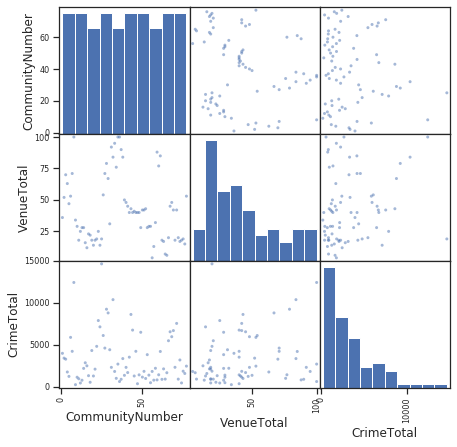

In [284]:
from pandas.plotting import scatter_matrix
columns = ['CommunityNumber','VenueTotal','CrimeTotal']
scatter_matrix(community_summary[columns],    figsize  = [7, 7])
pyplot.show()

Now we gather the communities with more crime and the communities with more residencies, this in order to try and establish a relation between crimes and residencies

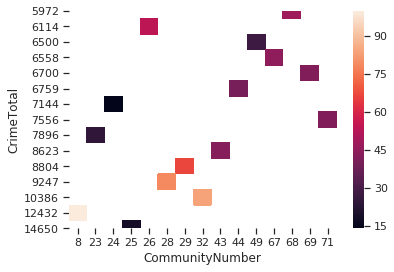

In [285]:
#Top 15 Crime Comunities
top15_crime = community_summary.nlargest(15,['CrimeTotal'])
#top15_crime.
crime_heat = sns.heatmap(top15_crime.pivot("CrimeTotal", "CommunityNumber", "VenueTotal"))

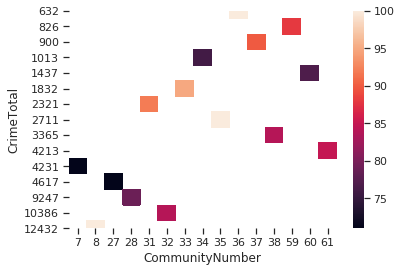

In [286]:
#Top 15 Comunities WITH more recidencies
top15_venue = community_summary.nlargest(15,['VenueTotal'])
#top15_crime.
venue_heat = sns.heatmap(top15_venue.pivot("CrimeTotal", "CommunityNumber", "VenueTotal"))

As seen in the above heatmaps **there is no relation** between a community having a high number of residencies and having a high crime rate

## Clustering

**Using k-means to get 5 clusters**

In [287]:
# set number of clusters
kclusters = 5

community_clustering = community_summary.drop('CommunityName', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(community_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 0, 0, 4, 2, 3, 0, 0], dtype=int32)

Categorizing our rows into clusters

In [288]:
# add clustering labels
data_merged = community_summary.copy()
data_merged.insert(0, 'ClusterLabels', kmeans.labels_)
data_merged.head() 

ClusterLabels  CommunityNumber   CommunityName  CommunityLatitude  \
0              2                1     Rogers Park          42.010531   
1              2                2      West Ridge          42.003548   
2              2                3          Uptown          41.966630   
3              0                4  Lincoln Square          41.975990   
4              0                5    North Center          41.956107   

   CommunityLongitude  VenueTotal  CrimeTotal  
0          -87.670748          36        3993  
1          -87.696243          52        3419  
2          -87.655546          70        3297  
3          -87.689616          63        1768  
4          -87.679160          47        1244

In [289]:
# create map
map_clusters = folium.Map(location=chicago_location, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_merged['CommunityLatitude'], data_merged['CommunityLongitude'], data_merged['CommunityName'], data_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters.save('ClusterMap.html')       
map_clusters

Examining each cluster

In [290]:
#Cluster 1
cluster1=data_merged.loc[data_merged['ClusterLabels'] == 0, data_merged.columns[[1] + list(range(3, data_merged.shape[1]))]]
#Cluster 2
cluster2=data_merged.loc[data_merged['ClusterLabels'] == 1, data_merged.columns[[1] + list(range(3, data_merged.shape[1]))]]
#Cluster 3
cluster3=data_merged.loc[data_merged['ClusterLabels'] == 2, data_merged.columns[[1] + list(range(3, data_merged.shape[1]))]]
#Cluster 4
cluster4=data_merged.loc[data_merged['ClusterLabels'] == 3, data_merged.columns[[1] + list(range(3, data_merged.shape[1]))]]
#Cluster 5
cluster5=data_merged.loc[data_merged['ClusterLabels'] == 4, data_merged.columns[[1] + list(range(3, data_merged.shape[1]))]]

The first cluster contains the most communities but these communities have the least crimes

In [291]:
print("Cluster 1: {0} communities, Cluster 2: {1} communities,Cluster 3: {2} communities,Cluster 4: {3} communities,Cluster 5: {4} communities ".format(cluster1.shape[0],cluster2.shape[0],cluster3.shape[0],cluster4.shape[0],cluster5.shape[0]))

Cluster 1: 44 communities, Cluster 2: 5 communities,Cluster 3: 16 communities,Cluster 4: 2 communities,Cluster 5: 10 communities 


In [292]:
#Cluster 1
cluster1

CommunityNumber  CommunityLatitude  CommunityLongitude  VenueTotal  \
3                 4          41.975990          -87.689616          63   
4                 5          41.956107          -87.679160          47   
8                 9          42.005733          -87.814016          34   
9                10          41.985590          -87.800582          29   
10               11          41.969738          -87.763118          18   
11               12          41.991752          -87.751674          25   
12               13          41.984955          -87.722933          28   
13               14          41.971937          -87.716174          28   
15               16          41.953365          -87.736447          12   
16               17          41.952809          -87.796449          23   
17               18          41.927744          -87.798457          22   
19               20          41.928643          -87.734502          14   
20               21          41.938921          -87.711168          18   
30               31          41.847620          -87.671774          92   
32               33          41.856700          -87.624774          95   
33               34          41.840033          -87.633107          76   
35               36          41.823653          -87.608242         100   
36               37          41.818089          -87.632551          90   
38               39          41.809144          -87.597991          50   
39               40          41.792534          -87.618105          48   
40               41          41.794225          -87.592562          45   
44               45          41.745035          -87.588658          41   
46               47          41.730035          -87.596714          40   
47               48          41.730035          -87.579213          40   
49               50          41.704124          -87.598299          42   
50               51          41.692236          -87.571703          42   
51               52          41.708020          -87.534827          43   
53               54          41.665809          -87.605344          29   
54               55          41.653646          -87.546988          29   
55               56          41.803617          -87.745489           4   
56               57          41.811422          -87.726165          13   
57               58          41.818922          -87.698942          32   
58               59          41.831700          -87.673664          88   
59               60          41.837938          -87.651028          77   
61               62          41.793922          -87.724498          18   
62               63          41.795033          -87.696164          17   
63               64          41.780588          -87.773388           7   
64               65          41.772811          -87.722275           6   
69               70          41.747533          -87.711163          18   
71               72          41.718153          -87.671767          20   
73               74          41.698089          -87.708662          18   
74               75          41.690312          -87.666716          19   
75               76          41.973101          -87.906768          15   
76               77          41.983369          -87.663952          53   

    CrimeTotal  
3         1768  
4         1244  
8          260  
9         1146  
10         960  
11         455  
12         787  
13        2198  
15        2503  
16        1329  
17         545  
19        1292  
20        2109  
30        2321  
32        1832  
33        1013  
35         632  
36         900  
38        1371  
39        2319  
40        1700  
44        1293  
46         372  
47        1425  
49        1159  
50        1846  
51         996  
53        1395  
54         492  
55        1834  
56         796  
57        2212  
58         826  
59        1437  
61         894  
62        2139  
63         921  
64        1681  
69        

The second cluster contains the communities with high amount of crimes

In [293]:
#Cluster 2
cluster2

CommunityNumber  CommunityLatitude  CommunityLongitude  VenueTotal  \
22               23          41.905767          -87.704174          25   
27               28          41.880066          -87.666762          79   
28               29          41.858151          -87.713881          67   
31               32          41.875562          -87.624421          84   
42               43          41.758728          -87.575283          43   

    CrimeTotal  
22        7896  
27        9247  
28        8804  
31       10386  
42        8623

Average set of communities

In [294]:
#Cluster 3
cluster3

CommunityNumber  CommunityLatitude  CommunityLongitude  VenueTotal  \
0                 1          42.010531          -87.670748          36   
1                 2          42.003548          -87.696243          52   
2                 3          41.966630          -87.655546          70   
6                 7          41.940298          -87.638117          71   
14               15          41.957809          -87.765059          16   
18               19          41.931698          -87.768670          18   
21               22          41.928568          -87.706793          19   
26               27          41.880866          -87.702833          71   
29               30          41.838215          -87.713273          31   
34               35          41.834857          -87.617954         100   
37               38          41.813923          -87.617272          84   
41               42          41.779479          -87.599493          40   
45               46          41.734587          -87.551322          40   
52               53          41.675046          -87.637823          28   
60               61          41.807533          -87.656440          85   
72               73          41.706423          -87.656160          17   

    CrimeTotal  
0         3993  
1         3419  
2         3297  
6         4231  
14        2865  
18        4324  
21        4823  
26        4617  
29        4419  
34        2711  
37        3365  
41        3535  
45        4233  
52        3835  
60        4213  
72        3199

as in the second cluster this one  contains the communities with high amount of crimes

In [295]:
#Cluster 4
cluster4

CommunityNumber  CommunityLatitude  CommunityLongitude  VenueTotal  \
7                 8          41.900033          -87.634497         100   
24               25          41.887876          -87.764851          19   

    CrimeTotal  
7        12432  
24       14650

In [296]:
#Cluster 5
cluster5

CommunityNumber  CommunityLatitude  CommunityLongitude  VenueTotal  \
5                 6          41.947050          -87.655429          53   
23               24          41.901421          -87.686166          14   
25               26          41.880588          -87.729223          54   
43               44          41.741145          -87.612548          40   
48               49          41.701979          -87.625881          28   
65               66          41.775033          -87.696441          20   
66               67          41.778089          -87.666718          45   
67               68          41.779756          -87.645884          48   
68               69          41.766886          -87.620845          42   
70               71          41.743387          -87.656042          42   

    CrimeTotal  
5         5892  
23        7144  
25        6114  
43        6759  
48        6500  
65        5493  
66        6558  
67        5972  
68        6700  
70        7556

Showing a heatmap with the communities that have the least amount of reported crimes

In [297]:
least_map = folium.Map(location=chicago_location,
                    zoom_start = 11) 

cluster1['CommunityLatitude'] = cluster1['CommunityLatitude'].astype(float)
cluster1['CommunityLongitude'] = cluster1['CommunityLongitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = cluster1[['CommunityLatitude', 'CommunityLongitude']]
heat_df = heat_df.dropna(axis=0, subset=['CommunityLatitude','CommunityLongitude'])

# List comprehension to make out list of lists
heat_data = [[row['CommunityLatitude'],row['CommunityLongitude']] for index, row in heat_df.iterrows()]
gradient = {.55: 'blue'}

# Plot it on the map
HeatMap(heat_data, radius=20,gradient=gradient).add_to(least_map)
least_map.save('LeastCrimesClusterMap.html')
# Display the map
least_map

And now we show the least safe communities( for these we can choose between cluster 2/4/5), we are using cluster 2

In [298]:
most_map = folium.Map(location=chicago_location,
                    zoom_start = 11) 

cluster2['CommunityLatitude'] = cluster2['CommunityLatitude'].astype(float)
cluster2['CommunityLongitude'] = cluster2['CommunityLongitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = cluster2[['CommunityLatitude', 'CommunityLongitude']]
heat_df = heat_df.dropna(axis=0, subset=['CommunityLatitude','CommunityLongitude'])

# List comprehension to make out list of lists
heat_data = [[row['CommunityLatitude'],row['CommunityLongitude']] for index, row in heat_df.iterrows()]
gradient = {.33: 'red'}

# Plot it on the map
HeatMap(heat_data, radius=20,gradient=gradient).add_to(most_map)
most_map.save('MostCrimesClusterMap.html')
# Display the map
most_map

Let's use a single map to show both clusters 

In [299]:
merged_map = folium.Map(location=chicago_location,
                    zoom_start = 11) 

#Getting heatmap data for the cluster with more crime data: cluster 2
cluster2['CommunityLatitude'] = cluster2['CommunityLatitude'].astype(float)
cluster2['CommunityLongitude'] = cluster2['CommunityLongitude'].astype(float)

heat_df = cluster2[['CommunityLatitude', 'CommunityLongitude']]
heat_df = heat_df.dropna(axis=0, subset=['CommunityLatitude','CommunityLongitude'])

heat_data = [[row['CommunityLatitude'],row['CommunityLongitude']] for index, row in heat_df.iterrows()]
gradient = {.33: 'red'}

HeatMap(heat_data, radius=20,gradient=gradient).add_to(merged_map)
########################################################################
#Getting heatmap data for the cluster with more crime data: cluster 1
cluster1['CommunityLatitude'] = cluster1['CommunityLatitude'].astype(float)
cluster1['CommunityLongitude'] = cluster1['CommunityLongitude'].astype(float)

heat_df1 = cluster1[['CommunityLatitude', 'CommunityLongitude']]
heat_df1 = heat_df1.dropna(axis=0, subset=['CommunityLatitude','CommunityLongitude'])

heat_data1 = [[row['CommunityLatitude'],row['CommunityLongitude']] for index, row in heat_df1.iterrows()]
gradient = {.55: 'blue'}

HeatMap(heat_data1, radius=20,gradient=gradient).add_to(merged_map)
merged_map.save('MergedClusterMap.html')
# Display the map
merged_map



## Results and Discussion <a name="results"></a>

Our study demonstrates that it does not matter how many residencies are in each community, the crime rate does not vary. Also our clusters have teached us the following:

* **The further from the city center the lower the crime rate** as shown in cluster 1, even though it has the most number of communities it has the least amount of crimes, in the map of cluster 1 we can see a diagonal pattern from city center to the outskirts. 

* The communities that were in the center of the city have a high crime rate, as shown in group 2, analyzing the map of group 2 we can see that **most of the heat is concentrated near the center**, without taking into account the single outlier to the right.

## Conclusion <a name="conclusion"></a>

The man objective of our study was to categorize communities as to show potential residents which areas are the best to live based on crime rate. And the **result shows clearly that everywhere not in the center is a good option**. Of course this is made based on ***Crime rate*, it would be good to add more variables like: rent cost, average income and transportation.